# 最尤推定

あるデータ$X$が得られた時，$Xの$尤度$p(X|\theta)$を最大化するパラメータ$\theta$を求める．  

$$
\argmax_{\theta} \, p(X|\theta)
$$

尤度とは，あるパラメータ$\theta$に従う確率分布からデータ集合$X=\{x_1, x_2, \cdots, x_n\}$が得られる確率のこと．  

$$
p(X) = \prod_{i=1}^n p(x_i)
$$

要は密度の積．

<br>

個人的な考え．確率モデルに関する記事などを読んでいると，「$p(x)$」という表記をよく見る．ただこれは尤度を表していたり，密度を表していたり，なんらかの分布を漠然と表していたりと，場面によって表すものが異なっている気がする．実際に↑の式だと，左辺は尤度，右辺は密度を表している．文脈をしっかり理解して，何を表しているのかを慎重に判断するのが大事な気がする．

In [1]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import random


---

## 総当たりで求める

$\theta$の値を全て試して求める．

参考
- [最尤推定量とは？初めての人にもわかる解説 | AVILEN AI Trend](https://ai-trend.jp/basic-study/estimator/maximum-likelihood-estimation/)

<br>

以下の問題を例題として考える

> 箱の中に10個の玉がある．玉の色は赤か白のいずれかである．  
箱の中からランダムに玉を取り出し，色を確認してから戻す．これを10回繰り返した．  
その結果，赤玉が3回，白玉が7回出てきた．さあ，箱の中には赤玉が何個あるだろうか．

箱の中身を直接覗くのはナシなので，確率の高い個数を求める問題となる．

では解いていく．

$x$を「赤が出た回数を表す確率変数」とすると，$x$は二項分布に従う．二項分布の確率密度関数は以下．  

$$
\mathrm{bin}(x; n, p) = {}_n C_x p^x (1-p)^{n-x}
$$


二項分布のパラメータは試行回数$n$と確率$p$で，今回の場合$n=10$が確定しており，$p$が推定したいパラメータとなる．この$p$は今後$\theta$と表記する．  
$\theta$は箱の中に入っている赤玉の割合を表す．正解の赤玉は3個なので，$\theta=\frac{3}{n}=0.3$が正解．

<br>

最尤推定ではまず尤度関数$L(\theta|X)$を設定する．これは，あるパラメータ$\theta$の下であるデータ$x$が得られる確率を返す，$\theta$についての関数である．$\theta$を変数として扱いたくて，$p(X|\theta)$だと$X$が変数っぽくなっちゃうから，逆にしたやつを考えただけ，みたいな認識でよい．  

$$
L(\theta|x) = p(X|\theta) = \mathrm{bin}(x; n, \theta) = {}_n C_x \theta^x (1-\theta)^{n-x}
$$

最尤推定で求めたいものは以下．

$$
\argmax_{\theta} \, p(x|\theta)
$$

今回はこれを総当たりで求める．この問題において，$\theta$は以下の11通りである．

In [2]:
theta = torch.arange(0, 10 + 1) / 10
theta

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

これら一つ一つで尤度を計算して，最大値を取った$\theta$を求める．

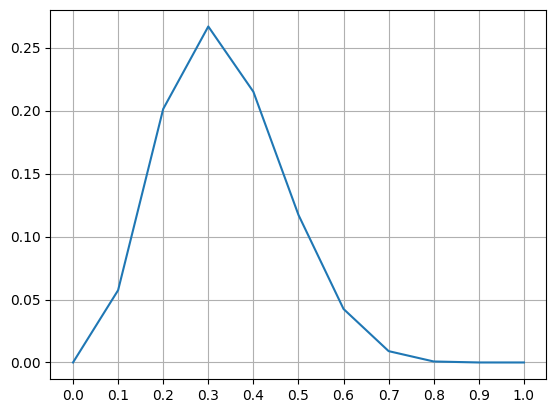

In [3]:
x = torch.tensor(3) # 実測値
n = 10 # 試行回数

binomal = dist.Binomial(n, theta) # 試行回数10, 確率psの二項分布
probs = binomal.log_prob(x).exp() # 分布から3が得られる確率
plt.plot(theta, probs)
plt.xticks(theta)
plt.grid();

$\theta = 0.3$が最も大きくなった．正解！これは**最尤推定量**と呼ぶ．  
以上より，箱の中には赤玉が$n \times \theta = 3$個あると推定できる．


---

## 解析的に求める

先ほどは$\theta$が離散値で且つ選択肢も少なかったので総当たりで求められたが，選択肢が多い場合やそもそも連続値の場合，総当たりには限界がある．  
そこで，解析的に（計算で）求める手法を考える．

やり方は簡単で，尤度関数を$\theta$について微分して，傾きが0になる$\theta$を求めるだけ．  
この時の尤度は正確には極大（小）値であるが，大体の場合は最大値を表している．最大値を表さない場合はこの手法を使えない（多分）．

またほとんどの場合，普通の尤度関数ではなく対数をとった**対数尤度関数**を考える．この方が計算しやすいから．$\log(x)$は単調増加関数で$\argmax_{\theta} p(X|\theta) = \argmax_{\theta} \log p(X|\theta)$が成り立つため，置き換えることが可能．

### 正規分布

正規分布を対象に最尤推定を行う．得られたデータを観察したら正規分布が適切だと感じたから，正確なパラメータを求めたいう，という場面．

正規分布のパラメータは平均$\mu$と分散$\sigma^2$で，これらを推定する訳だけど，直感的に考えたら，得られたデータの平均と分散がそのまま入りそうだなと思う．まあ実際その通り．でもこれは直感なので，ちゃんと数学的にも正しいことを証明していこう．

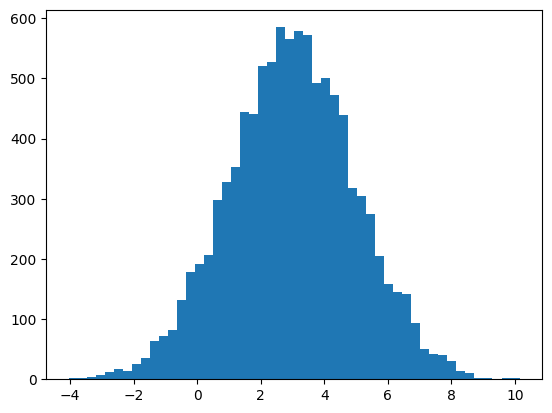

In [4]:
mu, sigma = 3, 2

n_samples = 10000
with pyro.plate('', size=n_samples):
    x = pyro.sample('', dist.Normal(mu, sigma))
plt.hist(x, bins=50);

こんなデータが得られたとする．確かに，正規分布を仮定するのが妥当に見える．  
では実際に求めていく．最初に書いた通り，対数尤度関数を最大にするパラメータを求める．正規分布のパラメータは平均$\mu$と分散$\sigma^2$で，↑の正解は$\mu=3, \sigma^2=2$．

<br>

まず適当に式変形していく．

$$
\begin{align}
\log L(\theta|X)
&= \log p(X|\theta) \\
&= \log \prod_{i=1}^n p(x_i|\theta) \\
&= \sum_{i=1}^n \log p(x_i|\theta) \\
&= \sum_{i=1}^n \log \left( \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{(x_i-\mu)^2}{2\sigma^2} \right) \right) \\
\end{align}
$$

こんな風に，対数にすると積を和にできる．これは微分をする上でとってもありがたいこと．

では，これを各パラメータ（$\mu$，$\sigma^2$）について微分して，最適な値を求める．  
一旦，分かり易いように対数尤度関数を$g(\mu, \sigma^2)$と置いて，さらに式を変形する．

$$
\begin{align}
g(\mu, \sigma^2)
&= \sum_{i=1}^n \log \left( \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{(x_i-\mu)^2}{2\sigma^2} \right) \right) \\
&= \sum_{i=1}^n \left( \log \left( \frac{1}{\sqrt{2\pi\sigma^2}} \right) + \log \left( \exp \left( -\frac{(x_i-\mu)^2}{2\sigma^2} \right) \right) \right) \\
&= \sum_{i=1}^n \left( -\frac{1}{2}\log(2\pi) - \log\sigma - \frac{(x_i-\mu)}{2\sigma^2} \right)
\end{align} \\
$$

ここから，微分していく

まずは$\mu$から

$$
\begin{align}
\frac{\partial g}{\partial\mu}
&= \frac{\partial}{\partial\mu} \sum_{i=1}^n -\frac{(x_i-\mu)^2}{2\sigma^2} \\
&= -\sum_{i=1}^n \frac{x_i-\mu}{\sigma}
\end{align}
$$

これが0になる$\mu$を求める．

$$
\begin{align}
-\sum_{i=1}^n \frac{x_i-\mu}{\sigma} &= 0 \\
(x_1-\mu) + (x_2-\mu) + \cdots + (x_n-\mu) &= 0 \\
(x_1 + x_2 + \cdots + x_n) - n\mu &= 0 \\
\frac{(x_1 + x_2 + \cdots + x_n)}{n} &= \mu
\end{align}
$$

ということで，無事$X$の平均値になった

では，今度は$\sigma^2$を求めていく．

$$
\begin{align}
\frac{\partial g}{\partial\sigma} &= -\sum_{i=1}^n \left( \frac{\partial}{\partial\sigma} \log\sigma + \frac{\partial}{\partial\sigma} \frac{(x_i-\mu)^2}{2\sigma^2} \right) \\
&= -\sum_{i=1}^n \left( \frac{1}{\sigma} - \frac{(x_i-\mu)^2}{\sigma^3} \right) \\
&= -\sum_{i=1}^n \left( \frac{\sigma^2 - (x_i-\mu)^2}{\sigma^3} \right)
\end{align}
$$

これが0になる$\sigma^2$を求める

$$
\begin{align}
-\sum_{i=1}^n \left( \frac{\sigma^2 - (x_i-\mu)^2}{\sigma^3} \right) &= 0 \\
\sum_{i=1}^n (x_i-\mu)^2 &= n\sigma^2 \\
\frac{\sum_{i=1}^n (x_i-\mu)^2}{n} &= \sigma^2 \\
\end{align}
$$

ということで，無事$X$の分散になった．

実際に得られたデータで算出してみる

In [5]:
mu_hat = x.mean()
sigma_hat = x.std()
print(f'mu: {mu_hat:.2f}, sigma: {sigma_hat:.2f}')

mu: 2.99, sigma: 1.99


正解の$\mu=3, \sigma^2=2$に近い値が求められた

### 二項分布

二項分布でもやってみる．さっきの例題を使う．

> 箱の中に10個の玉がある．玉の色は赤か白のいずれかである．  
箱の中からランダムに玉を取り出し，色を確認してから戻す．これを10回繰り返した．  
その結果，赤玉が3回，白玉が7回出てきた．さあ，箱の中には赤玉が何個あるだろうか．

求め方はさっきと一緒で，対数尤度関数を微分して0になるパラメータを求める．

では求めていこう，の前に，この問題は1つのパラメータを求める問題なので，尤度関数を可視化できる．せっかくなので見てみよう．

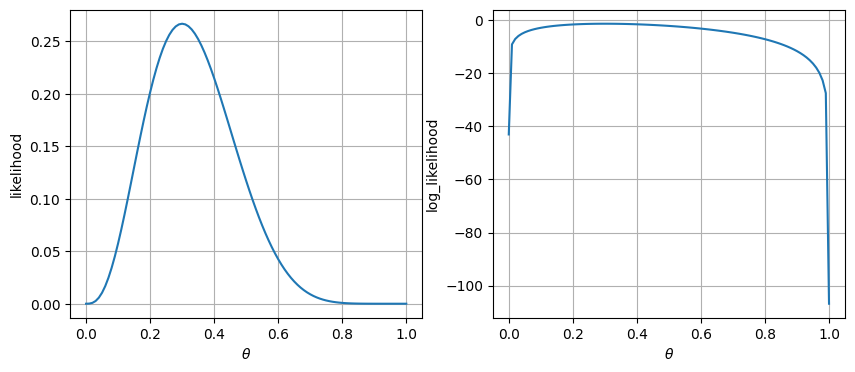

In [6]:
x = torch.tensor(3) # 実測値

p = torch.arange(0, 1 + 0.01, 0.01)
binomal = dist.Binomial(10, p)
log_likelihood = binomal.log_prob(x) # 対数尤度
likelihood = log_likelihood.exp() # 尤度
plt.figure(figsize=(10, 4))
for i, name in enumerate(['likelihood', 'log_likelihood']):
    plt.subplot(1, 2, i+1)
    plt.plot(p, eval(name))
    plt.xlabel(r'$\theta$')
    plt.ylabel(name)
    plt.grid();

ちゃんと上に凸な形になっていて，傾きが0になる唯一の$\theta$が最大値となっている．

では求めていこう．まずは対数尤度関数を変形する．

$$
\begin{align}
    \mathrm{log} \, L(\theta|x)
        &= \mathrm{log} \, \left( {}_n C_x \theta^x (1-\theta)^{n-x} \right) \\
        &= \mathrm{log} \, {}_n C_x + x \mathrm{log} \, \theta + (n-x) \mathrm{log} \, (1-\theta) \\ 
\end{align}
$$

次にこれを$\theta$で微分する

$$
\begin{align}
    \frac{\partial}{\partial\theta} \mathrm{log} \, L(\theta|x)
        &= 0 + \frac{x}{\theta} - \frac{n-x}{1-\theta} \\
        &= \frac{x(1-\theta) - (n-x)\theta}{\theta(1-\theta)} \\
        &= \frac{x - \theta n}{\theta(1-\theta)} \\
\end{align}
$$

でこれが0になる$\theta$を求める

$$
\begin{align}
    \frac{x - \theta n}{\theta(1-\theta)} &= 0 \\
    x - \theta n &= 0 \\
    \theta n &= x \\
    \theta &= \frac{x}{n} \\
\end{align}
$$

できた．  
$n=10, x=3$より，$\theta = \frac{3}{10} = 0.3$が最尤推定量となる．


---

## EMアルゴリズム

解析的な求め方ができない場合に役立つ手法．

<br>

先ほどの問題は二項分布という簡単な分布を用いたが，複雑な分布だと解析的に求めることも難しくなる．

例えば，以下の分布を考える．

$$
z \sim \mathrm{Bernoulli}(\theta) \\
x \sim \begin{cases}
    \mathrm{Normal}(0, 1) & (z=0) \\
    \mathrm{Normal}(5, 1) & (z=1)
\end{cases}
$$

$\theta$を0.7にしてサンプリングしてみる．

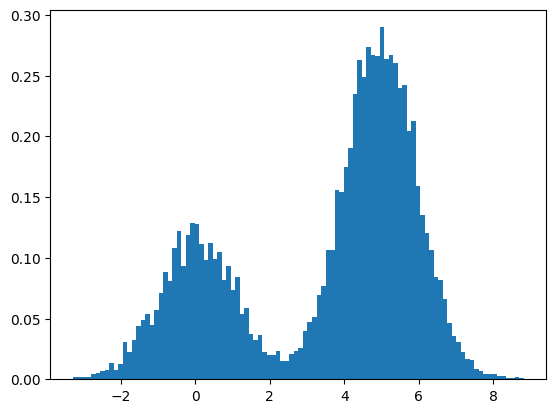

In [7]:
theta = 0.7
n = 10000

ber = dist.Bernoulli(theta)
norm0 = dist.Normal(0, 1)
norm1 = dist.Normal(5, 1)
def sampling(n):
    x = []
    for _ in range(n):
        z = ber.sample()
        if z == 0:
            x.append(norm0.sample())
        else:
            x.append(norm1.sample())
    return torch.tensor(x)

x = sampling(n)
plt.hist(x, bins=100, density=True);

このデータから$\theta$を予測する．

参考
- [EMアルゴリズムとともだちになろう | ドクセル](https://www.docswell.com/s/mutopsy/K18DP5-2022-08-16-163818#p17)
- [【徹底解説】EMアルゴリズムをはじめからていねいに | Academaid](https://academ-aid.com/ml/em)

まず尤度関数を考える．

$$
\mathrm{L}(\theta|x) = \prod_{i=1}^n p(x_i; \theta)
$$

次に対数尤度関数を考える．

$$
\begin{align}
    \mathrm{log} \, L(\theta|x)
        &= \mathrm{log} \, \prod_{i=1}^n p(x_i; \theta) \\
        &= \sum_{i=1}^n \log \, p(x_i; \theta) \\
\end{align}
$$

ここで，$p(x_i; \theta)$を周辺化する．

$$
p(x_i; \theta) = \sum_{j=0}^1 p(x_i, z_j; \theta)
$$

でこれを対数尤度関数に当てはめると

$$
\mathrm{log} \, L(\theta|x) = \sum_{i=1}^n \log \, \sum_{j=0}^1 p(x_i, z_j; \theta)
$$

$\log$の中に$\Sigma$が入ってしまった．これは計算が困難．

<br>

この様に，**潜在変数**が絡む分布の場合は$\log$の中に$\Sigma$が入ってしまって計算が困難になる．  
潜在変数とは，観測できない（表面に出てこない）が分布に影響を与える変数のこと．上の式でいうと$z$がそれに当たる．  
潜在変数が絡む分布の代表的な例は混合ガウス分布．こういった分布は尤度を潜在変数で周辺化することで$\log$の中に$\Sigma$が入るため，最尤推定が解析的に行えない．

そんな時に使うのがEMアルゴリズム．

まず周辺対数尤度をグラフにしてみる．

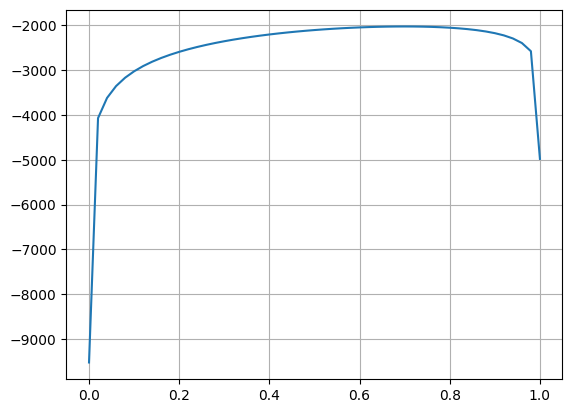

In [8]:
x = sampling(1000)
ps = torch.arange(0, 1 + 0.02, 0.02)

def log_likelihood(x, p):
    ber = dist.Bernoulli(p)
    ll = 0
    for xi in x:
        ll_ = 0
        ll_ += ber.log_prob(torch.tensor(0.)).exp() * norm0.log_prob(xi).exp()
        ll_ += ber.log_prob(torch.tensor(1.)).exp() * norm1.log_prob(xi).exp()
        ll += torch.log(ll_)
    return ll

lls = [log_likelihood(x, p) for p in ps]
plt.plot(ps, lls)
plt.grid();

こんな感じ．最大値も0.7を示してる．

In [9]:
idx = torch.argmax(torch.tensor(lls))
ps[idx]

tensor(0.7000)

（総当たりで求められるじゃんって思うかもしれないけど，$\theta$を0.02刻みで離散化して，サンプル数を1000に減らした上でこの計算時間なので，実用的では無い．）

では式変形をしていこう．  
まず**イェンゼンの不等式**を使って，対数尤度関数の下界を求める．

$$
\begin{align}
    \log L(\theta|x)
        &= \sum_{i=1}^n \log \sum_{j=0}^1 p(x_i, z_j; \theta) \\
        &= \sum_{i=1}^n \log \sum_{j=0}^1 \lambda_{ij} \frac{p(x_i, z_j; \theta)}{\lambda_{ij}} \quad \\
        &\geq \sum_{i=1}^n \sum_{j=0}^1 \lambda_{ij} \log \frac{p(x_i, z_j; \theta)}{\lambda_{ij}} \\
        &= \mathcal{L}(\theta|\lambda)
\end{align}
$$

$\lambda_{ij}$は$\sum_{j=0}^1 \lambda_{ij} = 1$を満たすなんらかの実数．$\mathcal{L}(\theta|\lambda)$が下界．

<br>

ここで，対数尤度関数と下界の差を求める．

$$
\log L(\theta|x) - \mathcal{L}(\theta|\lambda) = \mathrm{KL}[\lambda||p(z|x, \theta)]
$$

$\lambda$と$p(z|x, \theta)$のKLダイバージェンスになる．途中式は省略．これを以下のようにまとめる．

$$
\log L(\theta|x) = \mathrm{KL}[\lambda||p(z|x, \theta)] + \mathcal{L}(\theta|\lambda)
$$

対数尤度関数をKLダイバージェンスと下界の和で表すことが出来た．これを最大化することを考える．

以下を繰り返すことで，対数尤度関数を最大化する．

- $\theta$を固定し，KLダイバージェンスを最小化する（=0にする）$\lambda$を求める
- $\lambda$を固定し，下界を最大化する$\theta$を求める

このとき，$\theta$は更新するたびに対数尤度を大きくすることが証明されているらしい  
初めは$\theta$か$\lambda$のどちらかを乱数かなんかで初期化する必要がある．どちらでもいいみたいだが，$\theta$を初めに初期化するのが一般的．

では初めに$\theta$を固定し，KLダイバージェンスを最小化する$\lambda$を求める．  
これは簡単で，KLダイバージェンスは二つの分布が完全に一致する場合のみ0をとるので，$\lambda = p(z|x, \theta)$とすれば良い．もうちょい細かく書くと，$\lambda_{ij} = p(z_{ij}|x_i, \theta)$とする．これはベイズの定理を使った変換によって求める事が可能．

$$
\lambda_{ij} = p(z_{ij}|x_i, \theta) = \frac{p(x_i|z_j;\theta)p(z_{ij})}{p(x_i|z_{i0};\theta)p(z_{i0}) + p(x_i|z_{i1};\theta)p(z_{i1})}
$$

In [10]:
def kl_minimze(X, theta):
    n_samples = len(X)
    lmd = torch.zeros(n_samples, 2)
    for i, x in enumerate(X):
        l_0 = norm0.log_prob(x).exp() * (1 - theta)
        l_1 = norm1.log_prob(x).exp() * theta
        l = l_0 + l_1
        lmd[i, 0] = l_0 / l
        lmd[i, 1] = l_1 / l
    return lmd

次は$\lambda$を固定し，下界を最大化する$\theta$を求める．  
まず下界$\mathcal{L}(\theta|\lambda)$を変形する．前のステップで定めた$\theta$を$\theta_{old}$としておく

$$
\begin{align}
    \mathcal{L}(\theta|\lambda)
        &= \sum_{i=1}^n \sum_{j=0}^1 \lambda_j \log \, \frac{p(x_i, z_j; \theta)}{\lambda_j} \\
        &= \sum_{i=1}^n \sum_{j=0}^1 p(z_j|x_i; \theta_{old}) \log \frac{p(x_i, z_j; \theta)}{p(z_j|x_i; \theta_{old})} \\
        &= \sum_{i=1}^n \sum_{j=0}^1 p(z_j|x_i; \theta_{old}) \, \log p(x_i, z_j; \theta) + \mathrm{const} \\
        &= \mathcal{Q}(\theta|\theta_{old}) + \mathrm{const}
\end{align}
$$

$z$の事後分布の対数尤度に関する期待値になった．この期待値を求める過程を**Eステップ**と呼ぶ（期待値=*Expected Value*）．

次に，新たな$\theta$として，この下界を最大にする$\theta$を求める．

$$
\begin{align}
    \theta_{new}
        &= \argmax_\theta \, \mathcal{L}(\theta|\lambda) \\
        &= \argmax_\theta \, \mathcal{Q}(\theta|\theta_{old}) \\
        &= \argmax_\theta \, \sum_{i=1}^n \sum_{j=0}^1 p(z_j|x_i; \theta_{old}) \log p(x_i, z_j; \theta) \\
\end{align}
$$

これは偏微分で求められるらしい．

この時，$\log L(\theta_{new}) \ge \log L(\theta_{old})$が保証されるらしい．この下界を最大化する過程を**Mステップ**と呼ぶ（最大化=*Maximum*）．

EステップとMステップを繰り返すことから，EMアルゴリズムと呼ばれる．

### 混合ガウス分布

複数のガウス分布が混ざった分布の推定．

In [11]:
pi = [0.2, 0.3, 0.5]
mu = [-5., 0., 9.]
sigma = [1., 2., 2.]

norm = [dist.Normal(m, s) for m, s in zip(mu, sigma)]

def sampling(n):
    samples = []
    z = np.random.choice(range(3), size=n, p=pi)
    for zi in z:
        samples.append(norm[zi].sample())
    return torch.tensor(samples)

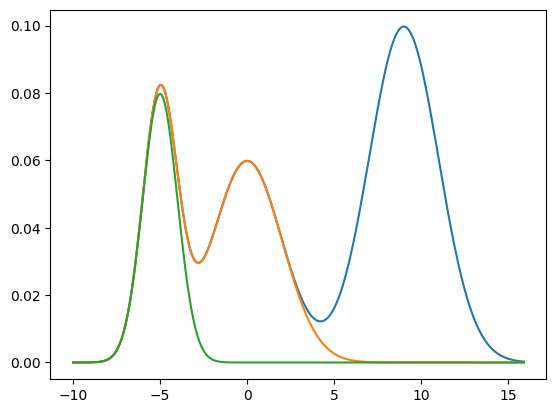

In [12]:
ax = torch.arange(-10, 16, 0.1)
y = torch.stack([p * n.log_prob(ax).exp() for n, p in zip(norm, pi)])
for i in range(1, 3):
    y[i] += y[i-1]
plt.plot(ax, y.T.flip(-1));

これが3つのガウス分布を足して作られた真の分布

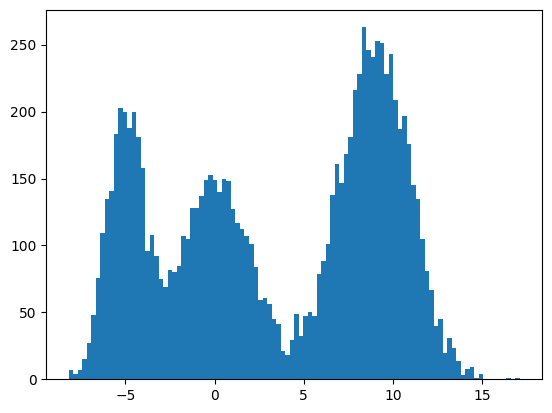

In [13]:
x = sampling(10000)
plt.hist(x, bins=100);

でこれがサンプリングしたデータ．このデータから真の分布を推定する．

まず，真の分布が混合ガウス分布であるという仮定をする．上のヒストグラムをみると，この仮定は妥当なハズ．  
混合ガウス分布のパラメータは，各ガウス分布の平均，分散，混合比率の3つ．

$$
p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x|\mu_k, \sigma_k^2)
$$

$K$はガウス分布の数で，上の例だと3が適切そう．

In [14]:
class GMM:
    def __init__(self, k):
        pass

    def pdf(self, x):
        dists = [dist.Normal(m, s) for m, s in zip(self.mu, self.sigma)]
        d = [p * norm.log_prob(x).exp() for norm, p in zip(dists, self.pi)]
        d = torch.stack(d).T
        return d

    def e_step(self, x):
        pdf = self.pdf(x)
        r = pdf / pdf.sum(dim=-1)
        return r

    def m_step(self, x, r):
        n = r.sum(dim=0)
        self.mu = torch.mv(x, r) / n
        self.sigma = 
        self.pi = n / self.n_samples

    def udpate(self, x, max_iter):
        for _ in range(max_iter):
            
        

SyntaxError: invalid syntax (3001663994.py, line 19)

In [ ]:
def init():
    pass

In [ ]:
def pdf(X):
    

In [ ]:
def e_step(X):
    


---

## EMアルゴリズム

解析的な求め方ができない場合に役立つ手法．  
先ほどの問題は二項分布という簡単な分布を用いたが，複雑な分布だと解析的に求めることも難しくなる．そんな時に使うのがEMアルゴリズム．

参考
- [【徹底解説】EMアルゴリズムをはじめからていねいに | Academaid](https://academ-aid.com/ml/em)

まず尤度関数を考える．

$$
\mathrm{L}(\theta|X) = \prod_{i=1}^n p(x_i; \theta)
$$

次に対数尤度関数を考える．

$$
\begin{align}
    \log L(\theta|X)
        &= \log \prod_{i=1}^n p(x_i; \theta) \\
        &= \sum_{i=1}^n \log \, p(x_i; \theta) \\
\end{align}
$$

ここで，$p(x_i; \theta)$を周辺化する．

$$
p(x_i; \theta) = \sum_{j=1}^m p(x_i, z_j; \theta)
$$

でこれを対数尤度関数に当てはめると

$$
\log L(\theta|X) = \sum_{i=1}^n \log \sum_{j=1}^m p(x_i, z_j; \theta)
$$

$\log$の中に$\Sigma$が入ってしまった．これは計算が困難．

では式変形をしていこう．  
まず**イェンゼンの不等式**を使って，対数尤度関数の下界を求める．

$$
\begin{align}
    \log L(\theta|X)
        &= \sum_{i=1}^n \log \sum_{j=0}^1 p(x_i, z_j; \theta) \\
        &= \sum_{i=1}^n \log \sum_{j=0}^1 \lambda_{ij} \frac{p(x_i, z_j; \theta)}{\lambda_{ij}} \quad \\
        &\geq \sum_{i=1}^n \sum_{j=0}^1 \lambda_{ij} \log \frac{p(x_i, z_j; \theta)}{\lambda_{ij}} \\
        &= \mathcal{L}(\theta|\lambda)
\end{align}
$$

$\lambda_{ij}$は$\sum_{j=0}^1 \lambda_{ij} = 1$を満たすなんらかの実数．$\mathcal{L}(\theta|\lambda)$が下界．

<br>

ここで，対数尤度関数と下界の差を求める．

$$
\log L(\theta|x) - \mathcal{L}(\theta|\lambda) = \mathrm{KL}[\lambda||p(z|x, \theta)]
$$

$\lambda$と$p(z|x, \theta)$のKLダイバージェンスになる．途中式は省略．これを以下のようにまとめる．

$$
\log L(\theta|x) = \mathrm{KL}[\lambda||p(z|x, \theta)] + \mathcal{L}(\theta|\lambda)
$$

対数尤度関数をKLダイバージェンスと下界の和で表すことが出来た．これを最大化することを考える．

以下を繰り返すことで，対数尤度関数を最大化する．

- $\theta$を固定し，KLダイバージェンスを最小化する（=0にする）$\lambda$を求める
- $\lambda$を固定し，下界を最大化する$\theta$を求める

このとき，$\theta$は更新するたびに対数尤度を大きくすることが証明されているらしい  
初めは$\theta$か$\lambda$のどちらかを乱数かなんかで初期化する必要がある．どちらでもいいみたいだが，$\theta$を初めに初期化するのが一般的．

では初めに$\theta$を固定し，KLダイバージェンスを最小化する$\lambda$を求める．  
これは簡単で，KLダイバージェンスは二つの分布が完全に一致する場合のみ0をとるので，$\lambda = p(z|x, \theta)$とすれば良い．もうちょい細かく書くと，$\lambda_{ij} = p(z_{ij}|x_i, \theta)$とする．これはベイズの定理を使った変換によって求める事が可能．

$$
\lambda_{ij} = p(z_{ij}|x_i, \theta) = \frac{p(x_i|z_j;\theta)p(z_{ij})}{p(x_i|z_{i0};\theta)p(z_{i0}) + p(x_i|z_{i1};\theta)p(z_{i1})}
$$

In [ ]:
def kl_minimze(X, theta):
    n_samples = len(X)
    lmd = torch.zeros(n_samples, 2)
    for i, x in enumerate(X):
        l_0 = norm0.log_prob(x).exp() * (1 - theta)
        l_1 = norm1.log_prob(x).exp() * theta
        l = l_0 + l_1
        lmd[i, 0] = l_0 / l
        lmd[i, 1] = l_1 / l
    return lmd

次は$\lambda$を固定し，下界を最大化する$\theta$を求める．  
まず下界$\mathcal{L}(\theta|\lambda)$を変形する．前のステップで定めた$\theta$を$\theta_{old}$としておく

$$
\begin{align}
    \mathcal{L}(\theta|\lambda)
        &= \sum_{i=1}^n \sum_{j=0}^1 \lambda_j \log \, \frac{p(x_i, z_j; \theta)}{\lambda_j} \\
        &= \sum_{i=1}^n \sum_{j=0}^1 p(z_j|x_i; \theta_{old}) \log \frac{p(x_i, z_j; \theta)}{p(z_j|x_i; \theta_{old})} \\
        &= \sum_{i=1}^n \sum_{j=0}^1 p(z_j|x_i; \theta_{old}) \, \log p(x_i, z_j; \theta) + \mathrm{const} \\
        &= \mathcal{Q}(\theta|\theta_{old}) + \mathrm{const}
\end{align}
$$

$z$の事後分布の対数尤度に関する期待値になった．この期待値を求める過程を**Eステップ**と呼ぶ（期待値=*Expected Value*）．

次に，新たな$\theta$として，この下界を最大にする$\theta$を求める．

$$
\begin{align}
    \theta_{new}
        &= \argmax_\theta \, \mathcal{L}(\theta|\lambda) \\
        &= \argmax_\theta \, \mathcal{Q}(\theta|\theta_{old}) \\
        &= \argmax_\theta \, \sum_{i=1}^n \sum_{j=0}^1 p(z_j|x_i; \theta_{old}) \log p(x_i, z_j; \theta) \\
\end{align}
$$

これは偏微分で求められるらしい．

この時，$\log L(\theta_{new}) \ge \log L(\theta_{old})$が保証されるらしい．この下界を最大化する過程を**Mステップ**と呼ぶ（最大化=*Maximum*）．

EステップとMステップを繰り返すことから，EMアルゴリズムと呼ばれる．

### 混合ガウス分布

複数のガウス分布が混ざった分布の推定．

In [ ]:
pi = [0.2, 0.3, 0.5]
mu = [-5., 0., 9.]
sigma = [1., 2., 2.]

norm = [dist.Normal(m, s) for m, s in zip(mu, sigma)]

def sampling(n):
    samples = []
    z = np.random.choice(range(3), size=n, p=pi)
    for zi in z:
        samples.append(norm[zi].sample())
    return torch.tensor(samples)

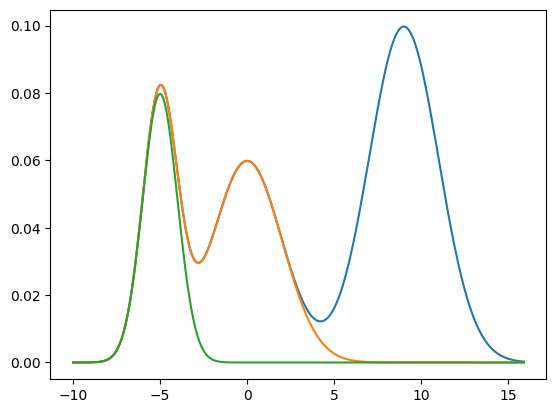

In [ ]:
ax = torch.arange(-10, 16, 0.1)
y = torch.stack([p * n.log_prob(ax).exp() for n, p in zip(norm, pi)])
for i in range(1, 3):
    y[i] += y[i-1]
plt.plot(ax, y.T.flip(-1));

これが3つのガウス分布を足して作られた真の分布

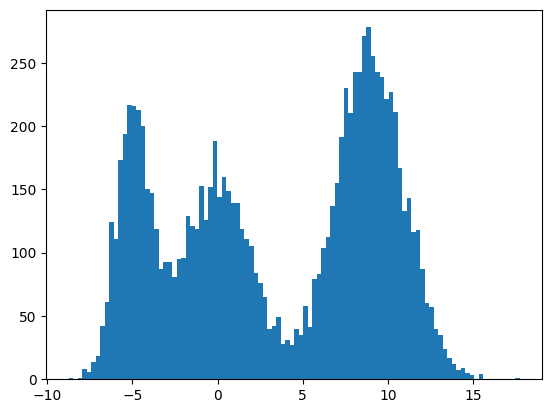

In [ ]:
x = sampling(10000)
plt.hist(x, bins=100);

でこれがサンプリングしたデータ．このデータから真の分布を推定する．

まず，真の分布が混合ガウス分布であるという仮定をする．上のヒストグラムをみると，この仮定は妥当なハズ．  
混合ガウス分布のパラメータは，各ガウス分布の平均，分散，混合比率の3つ．

$$
p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x|\mu_k, \sigma_k^2)
$$

$K$はガウス分布の数で，上の例だと3が適切そう．

In [ ]:
class GMM:
    def __init__(self, k):
        pass

    def pdf(self, x):
        dists = [dist.Normal(m, s) for m, s in zip(self.mu, self.sigma)]
        d = [p * norm.log_prob(x).exp() for norm, p in zip(dists, self.pi)]
        d = torch.stack(d).T
        return d

    def e_step(self, x):
        pdf = self.pdf(x)
        r = pdf / pdf.sum(dim=-1)
        return r

    def m_step(self, x, r):
        n = r.sum(dim=0)
        self.mu = torch.mv(x, r) / n
        self.sigma = 
        self.pi = n / self.n_samples

    def udpate(self, x, max_iter):
        for _ in range(max_iter):
            
        

---

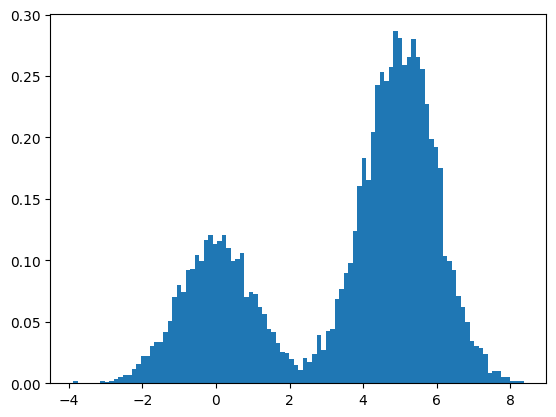

In [ ]:
theta = 0.7
n = 10000

ber = dist.Bernoulli(theta)
norm0 = dist.Normal(0, 1)
norm1 = dist.Normal(5, 1)
def sampling(n):
    x = []
    for _ in range(n):
        z = ber.sample()
        if z == 0:
            x.append(norm0.sample())
        else:
            x.append(norm1.sample())
    return torch.tensor(x)

x = sampling(n)
plt.hist(x, bins=100, density=True);

このデータから$\theta$を予測する．

参考
- [EMアルゴリズムとともだちになろう | ドクセル](https://www.docswell.com/s/mutopsy/K18DP5-2022-08-16-163818#p17)
- [【徹底解説】EMアルゴリズムをはじめからていねいに | Academaid](https://academ-aid.com/ml/em)

まず尤度関数を考える．

$$
\mathrm{L}(\theta|x) = \prod_{i=1}^n p(x_i; \theta)
$$

次に対数尤度関数を考える．

$$
\begin{align}
    \mathrm{log} \, L(\theta|x)
        &= \mathrm{log} \, \prod_{i=1}^n p(x_i; \theta) \\
        &= \sum_{i=1}^n \log \, p(x_i; \theta) \\
\end{align}
$$

ここで，$p(x_i; \theta)$を周辺化する．

$$
p(x_i; \theta) = \sum_{j=0}^1 p(x_i, z_j; \theta)
$$

でこれを対数尤度関数に当てはめると

$$
\mathrm{log} \, L(\theta|x) = \sum_{i=1}^n \log \, \sum_{j=0}^1 p(x_i, z_j; \theta)
$$

$\log$の中に$\Sigma$が入ってしまった．これは計算が困難．

<br>

この様に，**潜在変数**が絡む分布の場合は$\log$の中に$\Sigma$が入ってしまって計算が困難になる．  
潜在変数とは，観測できない（表面に出てこない）が分布に影響を与える変数のこと．上の式でいうと$z$がそれに当たる．  
潜在変数が絡む分布の代表的な例は混合ガウス分布．こういった分布は尤度を潜在変数で周辺化することで$\log$の中に$\Sigma$が入るため，最尤推定が解析的に行えない．

そんな時に使うのがEMアルゴリズム．

まず周辺対数尤度をグラフにしてみる．

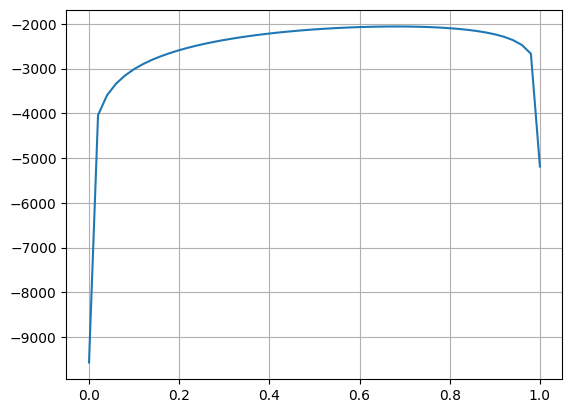

In [ ]:
x = sampling(1000)
ps = torch.arange(0, 1 + 0.02, 0.02)

def log_likelihood(x, p):
    ber = dist.Bernoulli(p)
    ll = 0
    for xi in x:
        ll_ = 0
        ll_ += ber.log_prob(torch.tensor(0.)).exp() * norm0.log_prob(xi).exp()
        ll_ += ber.log_prob(torch.tensor(1.)).exp() * norm1.log_prob(xi).exp()
        ll += torch.log(ll_)
    return ll

lls = [log_likelihood(x, p) for p in ps]
plt.plot(ps, lls)
plt.grid();

こんな感じ．最大値も0.7を示してる．

In [ ]:
idx = torch.argmax(torch.tensor(lls))
ps[idx]

tensor(0.6800)

（総当たりで求められるじゃんって思うかもしれないけど，$\theta$を0.02刻みで離散化して，サンプル数を1000に減らした上でこの計算時間なので，実用的では無い．）

では式変形をしていこう．  
まず**イェンゼンの不等式**を使って，対数尤度関数の下界を求める．

$$
\begin{align}
    \log L(\theta|x)
        &= \sum_{i=1}^n \log \sum_{j=0}^1 p(x_i, z_j; \theta) \\
        &= \sum_{i=1}^n \log \sum_{j=0}^1 \lambda_{ij} \frac{p(x_i, z_j; \theta)}{\lambda_{ij}} \quad \\
        &\geq \sum_{i=1}^n \sum_{j=0}^1 \lambda_{ij} \log \frac{p(x_i, z_j; \theta)}{\lambda_{ij}} \\
        &= \mathcal{L}(\theta|\lambda)
\end{align}
$$

$\lambda_{ij}$は$\sum_{j=0}^1 \lambda_{ij} = 1$を満たすなんらかの実数．$\mathcal{L}(\theta|\lambda)$が下界．

<br>

ここで，対数尤度関数と下界の差を求める．

$$
\log L(\theta|x) - \mathcal{L}(\theta|\lambda) = \mathrm{KL}[\lambda||p(z|x, \theta)]
$$

$\lambda$と$p(z|x, \theta)$のKLダイバージェンスになる．途中式は省略．これを以下のようにまとめる．

$$
\log L(\theta|x) = \mathrm{KL}[\lambda||p(z|x, \theta)] + \mathcal{L}(\theta|\lambda)
$$

対数尤度関数をKLダイバージェンスと下界の和で表すことが出来た．これを最大化することを考える．

以下を繰り返すことで，対数尤度関数を最大化する．

- $\theta$を固定し，KLダイバージェンスを最小化する（=0にする）$\lambda$を求める
- $\lambda$を固定し，下界を最大化する$\theta$を求める

このとき，$\theta$は更新するたびに対数尤度を大きくすることが証明されているらしい  
初めは$\theta$か$\lambda$のどちらかを乱数かなんかで初期化する必要がある．どちらでもいいみたいだが，$\theta$を初めに初期化するのが一般的．

では初めに$\theta$を固定し，KLダイバージェンスを最小化する$\lambda$を求める．  
これは簡単で，KLダイバージェンスは二つの分布が完全に一致する場合のみ0をとるので，$\lambda = p(z|x, \theta)$とすれば良い．もうちょい細かく書くと，$\lambda_{ij} = p(z_{ij}|x_i, \theta)$とする．これはベイズの定理を使った変換によって求める事が可能．

$$
\lambda_{ij} = p(z_{ij}|x_i, \theta) = \frac{p(x_i|z_j;\theta)p(z_{ij})}{p(x_i|z_{i0};\theta)p(z_{i0}) + p(x_i|z_{i1};\theta)p(z_{i1})}
$$

In [ ]:
def kl_minimze(X, theta):
    n_samples = len(X)
    lmd = torch.zeros(n_samples, 2)
    for i, x in enumerate(X):
        l_0 = norm0.log_prob(x).exp() * (1 - theta)
        l_1 = norm1.log_prob(x).exp() * theta
        l = l_0 + l_1
        lmd[i, 0] = l_0 / l
        lmd[i, 1] = l_1 / l
    return lmd

次は$\lambda$を固定し，下界を最大化する$\theta$を求める．  
まず下界$\mathcal{L}(\theta|\lambda)$を変形する．前のステップで定めた$\theta$を$\theta_{old}$としておく

$$
\begin{align}
    \mathcal{L}(\theta|\lambda)
        &= \sum_{i=1}^n \sum_{j=0}^1 \lambda_j \log \, \frac{p(x_i, z_j; \theta)}{\lambda_j} \\
        &= \sum_{i=1}^n \sum_{j=0}^1 p(z_j|x_i; \theta_{old}) \log \frac{p(x_i, z_j; \theta)}{p(z_j|x_i; \theta_{old})} \\
        &= \sum_{i=1}^n \sum_{j=0}^1 p(z_j|x_i; \theta_{old}) \, \log p(x_i, z_j; \theta) + \mathrm{const} \\
        &= \mathcal{Q}(\theta|\theta_{old}) + \mathrm{const}
\end{align}
$$

$z$の事後分布の対数尤度に関する期待値になった．この期待値を求める過程を**Eステップ**と呼ぶ（期待値=*Expected Value*）．

次に，新たな$\theta$として，この下界を最大にする$\theta$を求める．

$$
\begin{align}
    \theta_{new}
        &= \argmax_\theta \, \mathcal{L}(\theta|\lambda) \\
        &= \argmax_\theta \, \mathcal{Q}(\theta|\theta_{old}) \\
        &= \argmax_\theta \, \sum_{i=1}^n \sum_{j=0}^1 p(z_j|x_i; \theta_{old}) \log p(x_i, z_j; \theta) \\
\end{align}
$$

これは偏微分で求められるらしい．

この時，$\log L(\theta_{new}) \ge \log L(\theta_{old})$が保証されるらしい．この下界を最大化する過程を**Mステップ**と呼ぶ（最大化=*Maximum*）．

EステップとMステップを繰り返すことから，EMアルゴリズムと呼ばれる．